In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import folium
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

In [ ]:

tpl_validazioni_km = pd.read_parquet('data/tpl_validazioni_km(2).parquet')
dati_centraline = pd.read_parquet('data/dati-centraline-bologna-storico.parquet')
colonnine_conta_bici = gpd.read_parquet('data/colonnine-conta-bici(1).parquet')
bike_noleggi = pd.read_parquet('data/bike_noleggi.parquet')
rilevazione_flusso_veicoli_2023 = pd.read_parquet('data/rilevazione-flusso-veicoli-tramite-spire-anno-2023.parquet')
rilevazione_flusso_veicoli_2024 = pd.read_parquet('data/rilevazione-flusso-veicoli-tramite-spire-anno-2024.parquet')
rilevazione_flusso_veicoli_2025 = pd.read_parquet('data/rilevazione-flusso-veicoli-tramite-spire-anno-2025.parquet')
progetti_citta_30 = gpd.read_file('data/progetti-citta-30.geojson')
citta_30_area = gpd.read_file('data/citta-30-area-interessata-alla-citta-30.geojson')
precipitazioni = pd.read_parquet('data/precipitazioni_bologna.parquet')
temperature = pd.read_parquet('data/temperature_bologna.parquet')

In [ ]:

clima = pd.merge(
    left=precipitazioni,
    right=temperature,
    on='date',
    suffixes=('_prec', '_temp')
)

if 'stagione_temp' in clima.columns:
    clima.drop(columns=['stagione_temp'], inplace=True)
elif 'stagione_prec' in clima.columns:
    clima.drop(columns=['stagione_prec'], inplace=True)

clima.columns = clima.columns.str.strip().str.replace('#', '').str.replace(' ', '_')

clima.rename(columns={
    '184_avg_d': 'precipitazione_media',
    'avg': 'temperatura_media',
    'max': 'temperatura_massima',
    'min': 'temperatura_minima',
    'stagione_prec': 'stagione'
}, inplace=True)


In [ ]:
location_centraline = pd.DataFrame({
    'cod_staz': ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI', ],
    'LON_GEO': [11.354062, 11.327527, 11.285090],
    'LAT_GEO': [44.482671, 44.499060, 44.499134]
})

geometry = gpd.points_from_xy(location_centraline['LON_GEO'], location_centraline['LAT_GEO'])

geo_centraline = gpd.GeoDataFrame(
    location_centraline,
    geometry=geometry,
    crs='EPSG:4326'
)

In [ ]:
rilevazione_flusso_veicoli = pd.concat([rilevazione_flusso_veicoli_2023, rilevazione_flusso_veicoli_2024, rilevazione_flusso_veicoli_2025], axis=0, ignore_index=True)
rilevazione_flusso_veicoli['geometry'] = rilevazione_flusso_veicoli.apply(lambda row: Point(row['longitudine'], row['latitudine']), axis=1)
rilevazione_flusso_veicoli_2024_gdf = gpd.GeoDataFrame(rilevazione_flusso_veicoli, geometry='geometry', crs='EPSG:4326')
rilevazione_flusso_veicoli['data'] = pd.to_datetime(rilevazione_flusso_veicoli['data'])
pre_policy = rilevazione_flusso_veicoli[
    rilevazione_flusso_veicoli['data'].between('2023-01-04', '2024-01-03')
]
post_policy = rilevazione_flusso_veicoli[
    rilevazione_flusso_veicoli['data'].between('2024-01-04', '2025-01-03')
]

pre_policy

data    codice_spira  00_00_01_00  01_00_02_00  02_00_03_00  \
0      2023-04-01   0.127 1.5 2 1           34           31           14   
1      2023-04-01   0.127 1.5 5 1           38           29           20   
2      2023-04-01  0.127 1.13 6 1            0            0            0   
3      2023-04-01  0.127 1.15 6 1           68           50           38   
4      2023-04-01  0.127 1.82 2 2           86           55           37   
...           ...             ...          ...          ...          ...   
445037 2024-01-03   4.93 4.94 2 1           34           11            3   
445039 2024-01-03   4.94 4.17 4 1           29           17            8   
445041 2024-01-03   4.94 4.95 2 1           40           17            8   
445043 2024-01-03  4.98 0.127 4 1           24            9            4   
445045 2024-01-03   4.98 4.98 5 1           23           13            5   

        03_00_04_00  04_00_05_00  05_00_06_00  06_00_07_00  07_00_08_00  ...  \
0                 7            9           12           22           48  ...   
1                 6           13           12           18           21  ...   
2                 0            0            0            0            0  ...   
3                13           12           18           32           43  ...   
4                30           27           23           51          119  ...   
...             ...          ...          ...          ...          ...  ...   
445037            2            6           16           66          170  ...   
445039            4            9           10           38          117  ...   
445041            4            6           15           79          183  ...   
445043            2            7           14           29           73  ...   
445045            3            8           17           54          103  ...   

        stato  codimpsem  direzione  angolo  longitudine  latitudine  \
0           A        250          S   163.0    11.343595   44.501688   
1           A        250          N   343.0    11.343408   44.501173   
2           A        323          S   198.0    11.346420   44.491648   
3           A        324          S   168.0    11.343443   44.490027   
4           A         85         SE   217.0    11.349800   44.490458   
...       ...        ...        ...     ...          ...         ...   
445037      A        189          O    64.0    11.368050   44.484585   
445039      A        188          N   336.0    11.365767   44.485663   
445041      A        188          O    62.0    11.365325   44.485612   
445043      A        176         NO    69.0    11.385065   44.469348   
445045      A        348          N   352.0    11.385095   44.468055   

                                                 geopoint  chiave  \
0       b'\x01\x01\x00\x00\x00\x1cW\xd6\xba\xeb\xaf&@\...    16.0   
1       b'\x01\x01\x00\x00\x00\xc1b\x1d8\xd3\xaf&@>\xc...    17.0   
2       b'\x01\x01\x00\x00\x00\x1bR;\xf8]\xb1&@\xfc\xd...     3.0   
3       b'\x01\x01\x00\x00\x00n\xaa\x0e\xba\xd7\xaf&@\...     7.0   
4       b'\x01\x01\x00\x00\x00/#\xae\xf5\x18\xb3&@\xd4...    20.0   
...                                                   ...     ...   
445037  b'\x01\x01\x00\x00\x00\x0c\xd3\xe2\xfdp\xbc&@\...   911.0   
445039  b'\x01\x01\x00\x00\x00\xe5\xb1\x82\xc7E\xbb&@\...   912.0   
445041  b'\x01\x01\x00\x00\x00Q\x9c\xd6\xdf\x0b\xbb&@\...   915.0   
445043  b"\x01\x01\x00\x00\x00\x92\xc0\xbe:'\xc5&@r\xa...   920.0   
445045  b'\x01\x01\x00\x00\x00\x89X\x18\x1c+\xc5&@\xd4...   924.0   

        num_giorno_settimana                                   geometry  
0                     Sabato  POINT (11.3435953508993 44.5016875497437)  
1                     Sabato  POINT (11.3434083495971 44.5011734938257)  
2                     Sabato  POINT (11.3464200565732 44.4916483847646)  
3                     Sabato  POINT (11.3434427397635 44.4900271601578)  
4                     Sabato    POINT (11.34979980231 44.4904584072207)  
.

In [ ]:
m = folium.Map(location=[44.4949, 11.3426], zoom_start=13, tiles='OpenStreetMap')

folium.GeoJson(
    data=citta_30_area,
    style_function=lambda x: {
        'fillColor': 'green',
        'color': 'green',
        'weight': 2
    },
    name='30 km/h Area'
).add_to(m)

for _, row in progetti_citta_30.iterrows():
    folium.GeoJson(
        data=row['geometry'],
        style_function=lambda x: {
            'fillColor': 'red',
            'color': 'red',
            'weight': 1,
            'fillOpacity': 0.5
        },
        tooltip=folium.Tooltip(f"Project Info: {row.get('nome_new', 'No info available')}")
    ).add_to(m)

folium.LayerControl().add_to(m)

display(m)

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx

c30 = citta_30_area.to_crs(epsg=3857)
p30 = progetti_citta_30.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(10, 10))


c30.plot(
    ax=ax,
    facecolor='green',    
    edgecolor='green',    
    alpha=0.3,            
    linewidth=1
)


p30.plot(
    ax=ax,
    facecolor='red',
    edgecolor='red',
    alpha=0.5
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.savefig('bologna_30kmh_filled.png', dpi=300, bbox_inches='tight')
plt.close(fig)



In [ ]:
# Define the center of Bologna
bologna_center = [44.4949, 11.3426]

# Create a Folium map centered on Bologna
m = folium.Map(location=bologna_center, zoom_start=13, tiles='OpenStreetMap')

folium.GeoJson(
    data=citta_30_area,
    style_function=lambda x: {
        'fillColor': 'green',
        'color': 'green',
        'weight': 2
    },
    name='30 km/h Area'
).add_to(m)

traffic_sensors = rilevazione_flusso_veicoli_2024_gdf.groupby('geometry')


for geometry, group in traffic_sensors:
    folium.CircleMarker(
        location=[geometry.y, geometry.x],
        radius=1,
        color='purple',
        fill=True,
        fill_opacity=0.7,
        popup=f'{group.nome_via}'
    ).add_to(m)


display(m)



In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx


c30 = citta_30_area.to_crs(epsg=3857)
sensors = rilevazione_flusso_veicoli_2024_gdf.to_crs(epsg=3857)
bike_sensors = colonnine_conta_bici.to_crs(epsg=3857)
air_quality = geo_centraline.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))


c30.plot(
    ax=ax,
    facecolor='green',
    edgecolor='green',
    alpha=0.3,
    linewidth=1
)


sensors.plot(
    ax=ax,
    marker='o',
    color='blue',
    markersize=5,
    alpha=0.7
)


bike_sensors.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=20,
    alpha=0.7
)


air_quality.plot(
    ax=ax,
    marker='o',
    color='yellow',
    markersize=20,
    alpha=1
)


ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)


ax.set_axis_off()
plt.savefig('bologna_zones_and_sensors.png', dpi=300, bbox_inches='tight')
plt.close(fig)


In [ ]:
import folium
from folium.plugins import HeatMap
import re

data = rilevazione_flusso_veicoli


hour_columns = [col for col in data.columns if re.match(r'\d{2}_00_\d{2}_00', col)]


data = data.dropna(subset=['latitudine', 'longitudine'])


data['total_traffic'] = data[hour_columns].sum(axis=1)
aggregated = data.groupby(['latitudine', 'longitudine'], as_index=False)['total_traffic'].sum()


heat_data = [
    [row['latitudine'], row['longitudine'], row['total_traffic']]
    for _, row in aggregated.iterrows()
    if row['total_traffic'] > 0
]



m = folium.Map(location=[44.4949, 11.3426], zoom_start=13)


HeatMap(heat_data, radius=20, blur=15, max_zoom=1).add_to(m)




display(m)


In [ ]:


pre_policy['total_traffic'] = pre_policy[hour_columns].sum(axis=1)
pre_agg = (
    pre_policy
    .dropna(subset=['latitudine', 'longitudine'])
    .groupby(['latitudine', 'longitudine'], as_index=False)['total_traffic']
    .sum()
    .rename(columns={'total_traffic': 'total_traffic_pre'})
)

post_policy['total_traffic'] = post_policy[hour_columns].sum(axis=1)
post_agg = (
    post_policy
    .dropna(subset=['latitudine', 'longitudine'])
    .groupby(['latitudine', 'longitudine'], as_index=False)['total_traffic']
    .sum()
    .rename(columns={'total_traffic': 'total_traffic_post'})
)

traffic_diff = pd.merge(
    pre_agg, post_agg,
    on=['latitudine', 'longitudine'],
    how='inner'
)
traffic_diff['traffic_change'] = (
    traffic_diff['total_traffic_post']
  - traffic_diff['total_traffic_pre']
)

traffic_diff['pct_change'] = (
    traffic_diff['traffic_change']
    / traffic_diff['total_traffic_pre'].replace(0, np.nan)
)

clean_diff = traffic_diff.loc[
    traffic_diff['pct_change'].abs() <= 0.99
].copy()

clean_diff = clean_diff.dropna(subset=['pct_change'])


/tmp/ipykernel_47332/3794134691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_policy['total_traffic'] = pre_policy[hour_columns].sum(axis=1)
/tmp/ipykernel_47332/3794134691.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_policy['total_traffic'] = post_policy[hour_columns].sum(axis=1)


In [ ]:
total_pre = pre_agg['total_traffic_pre'].sum()
total_post = post_agg['total_traffic_post'].sum()

total_diff = total_post - total_pre
total_pct_change = (total_diff / total_pre) * 100

print(f"Total traffic before policy: {total_pre}")
print(f"Total traffic after policy:  {total_post}")
print(f"Absolute change:              {total_diff}")
print(f"Percent change:               {total_pct_change:.2f}%")


Total traffic before policy: 1810881860
Total traffic after policy:  1676102531
Absolute change:              -134779329
Percent change:               -7.44%


In [13]:
clean_diff

latitudine  longitudine  total_traffic_pre  total_traffic_post  \
0     44.448146    11.359286            2751160              284405   
1     44.448204    11.359239            3551105             2912249   
2     44.448336    11.359417             332694              285748   
3     44.448772    11.360029            2966256             2712427   
4     44.450419    11.361584            3593878             3333046   
..          ...          ...                ...                 ...   
852   44.548375    11.363414             405506              392836   
853   44.550283    11.357167            1499422             1437595   
854   44.550583    11.358181             871927              996468   
855   44.550637    11.358182            1483677             1394405   
856   44.550970    11.356617            3271968             3137126   

     traffic_change  pct_change  
0          -2466755   -0.896624  
1           -638856   -0.179903  
2            -46946   -0.141109  
3           -253829   -0.085572  
4           -260832   -0.072577  
..              ...         ...  
852          -12670   -0.031245  
853          -61827   -0.041234  
854          124541    0.142834  
855          -89272   -0.060169  
856         -134842   -0.041211  

[797 rows x 6 columns]

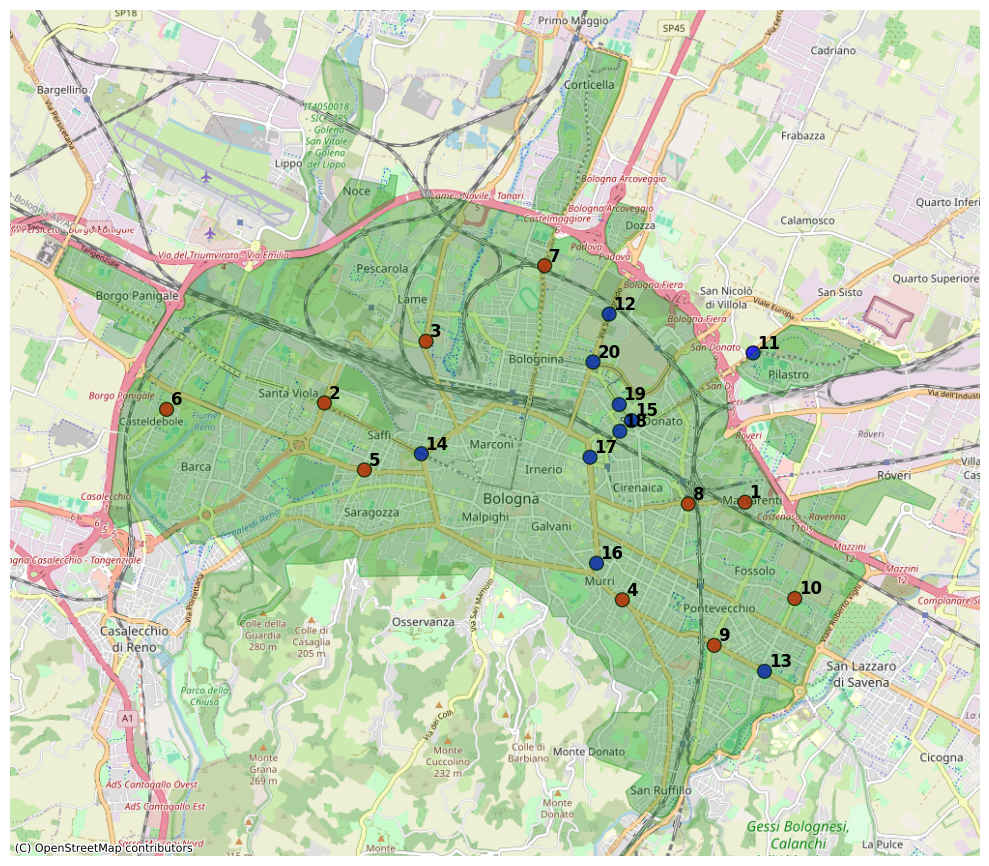

Label   Latitude  Longitude  Pre-Policy  Post-Policy  Δ Traffic  \
357      1  44.493345  11.384168     2858616      5096250    2237634   
626      2  44.505929  11.309446     2980397      4900642    1920245   
735      3  44.513741  11.327502     2795881      4472380    1676499   
173      4  44.480982  11.362377     3045931      4721652    1675721   
426      5  44.497435  11.316552     4304109      5958848    1654739   
601      6  44.505112  11.281404     2411820      3749989    1338169   
810      7  44.523315  11.348570     1980771      3260175    1279404   
347      8  44.493138  11.374100     1542156      2720168    1178012   
98       9  44.475210  11.378696     3226430      4371611    1145181   
178     10  44.481150  11.393006     1987856      2900691     912835   
725     11  44.512259  11.385614    13479681      5335956   -8143725   
766     12  44.517190  11.360034    11735406      4234837   -7500569   
70      13  44.471919  11.387634    10653681      5349057   -5304624   
472     14  44.499494  11.326669     5545002      1333548   -4211454   
567     15  44.503693  11.364002     3804647       310205   -3494442   
219     16  44.485616  11.357787     6951114      4165703   -2785411   
464     17  44.499050  11.356628     6607826      3961282   -2646544   
535     18  44.502340  11.361930     3059478       456619   -2602859   
623     19  44.505725  11.361822     2992088       438196   -2553892   
703     20  44.511107  11.357166     5947966      3444408   -2503558   

      % Change  
357  78.276830  
626  64.429168  
735  59.963174  
173  55.015068  
426  38.445564  
601  55.483784  
810  64.591212  
347  76.387343  
98   35.493750  
178  45.920580  
725 -60.414820  
766 -63.914014  
70  -49.791466  
472 -75.950451  
567 -91.846681  
219 -40.071433  
464 -40.051660  
535 -85.075264  
623 -85.354843  
703 -42.090994

\begin{table}
\caption{Top 10 Locations by Largest Positive and Negative Traffic Changes}
\label{tab:traffic_changes_map}
\begin{tabular}{rrrrrrr}
\toprule
Label & Latitude & Longitude & Pre-Policy & Post-Policy & Δ Traffic & % Change \\
\midrule
1 & 44.49 & 11.38 & 2858616 & 5096250 & 2237634 & 78.28 \\
2 & 44.51 & 11.31 & 2980397 & 4900642 & 1920245 & 64.43 \\
3 & 44.51 & 11.33 & 2795881 & 4472380 & 1676499 & 59.96 \\
4 & 44.48 & 11.36 & 3045931 & 4721652 & 1675721 & 55.02 \\
5 & 44.50 & 11.32 & 4304109 & 5958848 & 1654739 & 38.45 \\
6 & 44.51 & 11.28 & 2411820 & 3749989 & 1338169 & 55.48 \\
7 & 44.52 & 11.35 & 1980771 & 3260175 & 1279404 & 64.59 \\
8 & 44.49 & 11.37 & 1542156 & 2720168 & 1178012 & 76.39 \\
9 & 44.48 & 11.38 & 3226430 & 4371611 & 1145181 & 35.49 \\
10 & 44.48 & 11.39 & 1987856 & 2900691 & 912835 & 45.92 \\
11 & 44.51 & 11.39 & 13479681 & 5335956 & -8143725 & -60.41 \\
12 & 44.52 & 11.36 & 11735406 & 4234837 & -7500569 & -63.91 \\
13 & 44.47 & 11.39 & 10653681 & 53490

In [ ]:
top_pos = clean_diff.nlargest(10, 'traffic_change')
top_neg = clean_diff.nsmallest(10, 'traffic_change')
top5 = pd.concat([top_pos, top_neg]).copy()


top5 = top5.rename(columns={
    'latitudine':'Latitude', 'longitudine':'Longitude',
    'total_traffic_pre':'Pre-Policy', 'total_traffic_post':'Post-Policy',
    'traffic_change':'Δ Traffic', 'pct_change':'% Change'
})


c30 = citta_30_area.to_crs(epsg=3857)


top5.insert(0, 'Label', range(1, len(top5)+1))

gdf = gpd.GeoDataFrame(
    top5,
    geometry=gpd.points_from_xy(top5.Longitude, top5.Latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)

gdf['color'] = np.where(gdf['Δ Traffic'] > 0, 'red', 'blue')

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    ax=ax,
    color=gdf['color'],
    markersize=100,
    alpha=0.8,
    edgecolor='k'
)

c30.plot(
    ax=ax,
    facecolor='green',
    edgecolor='green',
    alpha=0.3,
    linewidth=1
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

for _, row in gdf.iterrows():
    ax.annotate(
        str(row['Label']),
        xy=(row.geometry.x, row.geometry.y),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=12,
        fontweight='bold',
        color='black'
    )

ax.set_axis_off()
plt.tight_layout()
plt.show()

top5['% Change'] = top5['% Change']*100

display(top5[['Label','Latitude','Longitude','Pre-Policy','Post-Policy','Δ Traffic','% Change']])

latex_table = top5[
    ['Label','Latitude','Longitude','Pre-Policy','Post-Policy','Δ Traffic','% Change']
].to_latex(
    index=False,
    caption='Top 10 Locations by Largest Positive and Negative Traffic Changes',
    label='tab:traffic_changes_map',
    float_format="%.2f"       
)

print(latex_table)


In [ ]:
data = clean_diff

neg_min = data.loc[data.traffic_change < 0, 'traffic_change'].min()
pos_max = data.loc[data.traffic_change > 0, 'traffic_change'].max()


neg_min = float(neg_min) if not np.isnan(neg_min) else 0.0
pos_max = float(pos_max) if not np.isnan(pos_max) else 0.0

neg_heat = []
pos_heat = []

for _, row in data.iterrows():
    tc = row['traffic_change']
    lat, lon = row['latitudine'], row['longitudine']
    if tc < 0 and neg_min != 0:
        raw = (tc - neg_min) / (0 - neg_min)
        neg_heat.append([lat, lon, raw])
    elif tc > 0 and pos_max != 0:
        raw = tc / pos_max
        pos_heat.append([lat, lon, raw])

m = folium.Map(location=[44.4949, 11.3426], zoom_start=13)

HeatMap(
    neg_heat,
    gradient={0.0: 'blue', 1.0: 'white'},
    radius=20,
    blur=15,
    min_opacity=0.3,  
    max_val=1.0,
    name='Negative change'
).add_to(m)

HeatMap(
    pos_heat,
    gradient={0.0: 'white', 1.0: 'red'},
    radius=20,
    blur=15,
    min_opacity=0.3,
    max_val=1.0,
    name='Positive change'
).add_to(m)

folium.LayerControl().add_to(m)

m


/tmp/ipykernel_47332/1629578341.py:32: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(
/tmp/ipykernel_47332/1629578341.py:43: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(


/home/filippo/anaconda3/envs/dataviz/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 22 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Global Moran's I = 0.062, p = 0.014


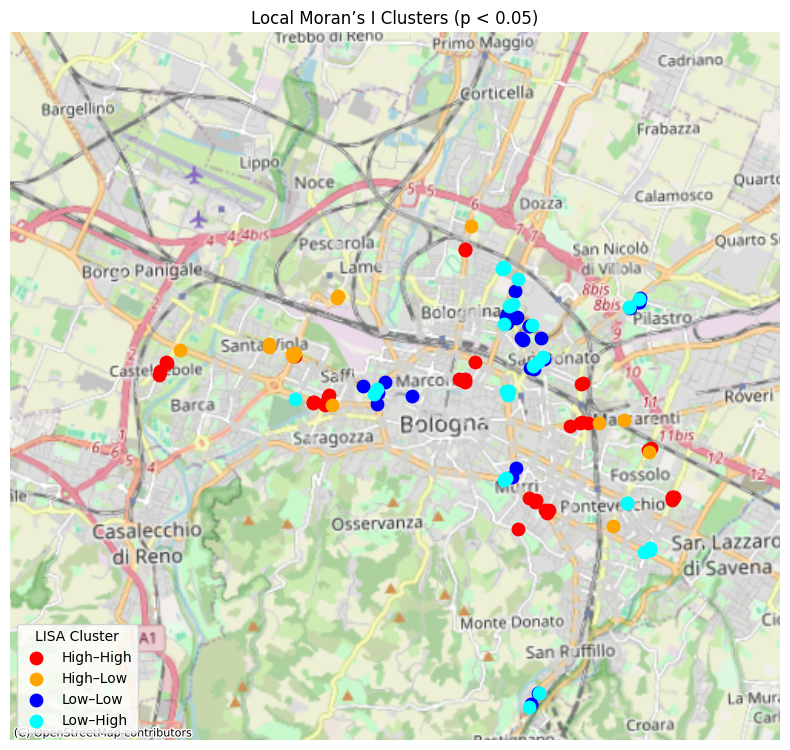

quadrant
High–High    43
Low–High     31
Low–Low      27
High–Low     14
Name: count, dtype: int64


In [ ]:

from libpysal.weights import KNN
from esda import Moran, Moran_Local


gdf = gpd.GeoDataFrame(
    clean_diff,
    geometry=gpd.points_from_xy(
        clean_diff.longitudine,
        clean_diff.latitudine
    ),
    crs="EPSG:4326"  
)

gdf = gdf.to_crs(epsg=32632)


w = KNN.from_dataframe(gdf, k=5)
w.transform = "R"

y = gdf["traffic_change"].values
mi = Moran(y, w, permutations=999)
print(f"Global Moran's I = {mi.I:.3f}, p = {mi.p_sim:.3f}")


lisa = Moran_Local(y, w, permutations=999)

gdf["local_I"]   = lisa.Is       
gdf["local_p"]   = lisa.p_sim    
gdf["quadrant"]  = lisa.q       


sig = gdf[gdf["local_p"] < 0.05]


quad_colors = {
    1: "red",     # High‐High
    2: "orange",  # High‐Low
    3: "blue",    # Low‐Low
    4: "cyan"     # Low‐High
}

fig, ax = plt.subplots(figsize=(8,8))

gdf.plot(ax=ax, color="lightgrey", markersize=20, alpha=0.5)


for quad, color in quad_colors.items():
    subset = sig[sig["quadrant"] == quad]
    subset.plot(
        ax=ax,
        color=color,
        markersize=80,
        label={1:"High–High",
               2:"High–Low",
               3:"Low–Low",
               4:"Low–High"}[quad]
    )


ctx.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    source=ctx.providers.OpenStreetMap.Mapnik
)

ax.set_title("Local Moran’s I Clusters (p < 0.05)")
ax.axis("off")
ax.legend(title="LISA Cluster", loc="lower left")

plt.tight_layout()
plt.show()


cluster_counts = sig["quadrant"].map({
    1: "High–High",
    2: "High–Low",
    3: "Low–Low",
    4: "Low–High"
}).value_counts()
print(cluster_counts)


In [ ]:

dati_centraline = dati_centraline.merge(location_centraline, on='cod_staz', how='left')

dati_centraline['data'] = pd.to_datetime(dati_centraline['data_inizio'])

pre_policy = dati_centraline[
    dati_centraline['data'].between('2023-01-04', '2024-01-03')
]
post_policy = dati_centraline[
    dati_centraline['data'].between('2024-01-04', '2025-01-03')
]




In [ ]:
def prepare(df, period_label):
    df = (
        df.dropna(subset=["LON_GEO", "LAT_GEO"])
          .set_index("data")
          .groupby(["cod_staz", "agente"])["valore"]
          .resample("D")
          .mean()
          .reset_index()
    )
    df["period"] = period_label
    return df

df_pre  = prepare(pre_policy,  "pre")
df_post = prepare(post_policy, "post")
df      = pd.concat([df_pre, df_post], ignore_index=True)

policy_start = df.loc[df.period == "post", "data"].min()


stations   = df["cod_staz"].unique()
pollutants = df["agente"].unique()
cmap       = plt.get_cmap("tab10")
colors     = {st: cmap(i % 10) for i, st in enumerate(stations)}


chunks = [pollutants[i:i + 4] for i in range(0, len(pollutants), 4)]

for idx, chunk in enumerate(chunks, 1):
    nrows = len(chunk)
    fig, axes = plt.subplots(nrows=nrows, ncols=1,
                             figsize=(10, 4 * nrows), sharex=True)

    if nrows == 1:
        axes = [axes]  

    for ax, pollutant in zip(axes, chunk):
        for st in stations:
            grp = df[(df.cod_staz == st) & (df.agente == pollutant)]
            if grp.empty:
                continue
            ts = grp.set_index("data")["valore"].rolling(7, min_periods=1).mean()
            ax.plot(ts.index, ts.values, label=f"Station {st}",
                    color=colors[st], linewidth=1.5)

        ax.axvline(policy_start, color="black", linestyle="--", linewidth=1)
        ax.set_title(f"{pollutant} concentration (7-day rolling mean)")
        ax.set_ylabel("Daily mean")
        ax.legend(title="Station", fontsize="x-small", ncol=2,
                  loc="upper left", frameon=False)
    axes[-1].set_xlabel("Date")
    axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(
                                        axes[-1].xaxis.get_major_locator()))

    fig.tight_layout()
    fig.savefig(f"pollutants_part{idx}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)


In [ ]:

import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu

pre_aq  = pre_policy
post_aq = post_policy
def prepare_aq(df, label):
    df = (
        df
        .dropna(subset=["LON_GEO", "LAT_GEO"])
        .set_index("data")
        .groupby(["cod_staz", "agente"])["valore"]
        .resample("D")
        .mean()
        .reset_index()
    )
    df["period"] = label
    return df

df_pre  = prepare_aq(pre_aq,  "pre")
df_post = prepare_aq(post_aq, "post")
aq = pd.concat([df_pre, df_post], ignore_index=True)

# Climate data
climate = clima
climate = climate.rename(columns={
    "date":                  "data",
    "precipitazione_media":  "precip_mm",
    "temperatura_media":     "temp_mean",
    "temperatura_massima":   "temp_max",
    "temperatura_minima":    "temp_min",
    "stagione":              "season"
})
climate["data"] = pd.to_datetime(climate["data"])

# Make sure both are naive datetimes before merge
aq["data"]      = aq["data"].dt.tz_localize(None)
climate["data"] = climate["data"].dt.tz_localize(None)

# merge on date only (town‐wide weather)
df = aq.merge(climate, on="data", how="left")
df["month"] = df["data"].dt.month

# --- 3. Regression adjustment per station×pollutant ---
regression_results = []
for (st, pol), grp in df.groupby(["cod_staz","agente"]):
    # model: pollutant ~ policy + weather + seasonality
    formula = "valore ~ C(period) + temp_mean + precip_mm + C(season)"
    m = smf.ols(formula, data=grp).fit()
    regression_results.append({
        "station":    st,
        "pollutant":  pol,
        "coef_post":  m.params.get("C(period)[T.post]", np.nan),
        "pval_post":  m.pvalues.get("C(period)[T.post]", np.nan),
        "r_squared":  m.rsquared
    })
reg_df = pd.DataFrame(regression_results)

# --- 4. Independent Mann–Whitney U stratified by wet/dry days ---
mw_results = []
for (st, pol), grp in df.groupby(["cod_staz","agente"]):
    for cond, mask in [("dry", grp.precip_mm == 0),
                       ("wet", grp.precip_mm > 0)]:
        pre_vals  = grp.loc[mask & (grp.period=="pre"),  "valore"].dropna()
        post_vals = grp.loc[mask & (grp.period=="post"), "valore"].dropna()
        if len(pre_vals)>10 and len(post_vals)>10:
            stat, p = mannwhitneyu(pre_vals, post_vals, alternative="two-sided")
            mw_results.append({
                "station":    st,
                "pollutant":  pol,
                "condition":  cond,
                "n_pre":      len(pre_vals),
                "n_post":     len(post_vals),
                "mw_stat":    stat,
                "p_value":    p
            })
mw_df = pd.DataFrame(mw_results)
print("=== Stratified Mann–Whitney U Results ===")
print(mw_df)


# --- 5. Residual‐based Wilcoxon test ---
# fit weather+season on pre‐policy only
pre_only = df[df.period=="pre"].copy()
base_mod = smf.ols("valore ~ temp_mean + precip_mm + C(season)", data=pre_only).fit()

# compute residuals for all days
df["residual"] = df["valore"] - base_mod.predict(df)

mw_resid = []
for (st, pol), grp in df.groupby(["cod_staz","agente"]):
    pre_r  = grp.loc[grp.period=="pre",  "residual"].dropna()
    post_r = grp.loc[grp.period=="post", "residual"].dropna()
    if len(pre_r)>10 and len(post_r)>10:
        stat, p = mannwhitneyu(pre_r, post_r, alternative="two-sided")
        mw_resid.append({
            "station":    st,
            "pollutant":  pol,
            "n_pre":      len(pre_r),
            "n_post":     len(post_r),
            "mw_stat":    stat,
            "p_value":    p
        })
mw_resid_df = pd.DataFrame(mw_resid)
print("\n=== Residual‐Based Mann–Whitney U Results ===")
print(mw_resid_df)

# --- 6. Summarize results ---
summary = (
    reg_df
    .merge(
        mw_resid_df.rename(columns={"wilcox_stat":"resid_w_stat","p_value":"resid_p"}),
        on=["station","pollutant"],
        how="left"
    )
    .merge(
        mw_df.rename(columns={"wilcox_stat":"strat_w_stat","p_value":"strat_p"}),
        on=["station","pollutant"],
        how="left"
    )
)
print(summary)

=== Stratified Mann–Whitney U Results ===
                station                   pollutant condition  n_pre  n_post  \
0   GIARDINI MARGHERITA     NO2 (BIOSSIDO DI AZOTO)       dry    238     216   
1   GIARDINI MARGHERITA     NO2 (BIOSSIDO DI AZOTO)       wet    125     149   
2   GIARDINI MARGHERITA                  O3 (OZONO)       dry    238     216   
3   GIARDINI MARGHERITA                  O3 (OZONO)       wet    125     149   
4   GIARDINI MARGHERITA                        PM10       dry    234     208   
5   GIARDINI MARGHERITA                        PM10       wet    116     140   
6   GIARDINI MARGHERITA                       PM2.5       dry    223     208   
7   GIARDINI MARGHERITA                       PM2.5       wet    121     146   
8      PORTA SAN FELICE              C6H6 (BENZENE)       dry    236     214   
9      PORTA SAN FELICE              C6H6 (BENZENE)       wet    125     148   
10     PORTA SAN FELICE  CO (MONOSSIDO DI CARBONIO)       dry    238     216  

In [ ]:

pre_policy = colonnine_conta_bici[
    colonnine_conta_bici['data'].between('2023-01-04', '2024-01-03')
]
post_policy = colonnine_conta_bici[
    colonnine_conta_bici['data'].between('2024-01-04', '2025-01-03')
]

common_colonnine = pre_policy['colonnina'].unique()

post_policy_filtered = post_policy[
    post_policy['colonnina'].isin(common_colonnine)
]


In [19]:
total_bikes_pre = pre_policy['totale'].sum()
total_bikes_post = post_policy_filtered['totale'].sum()
bikes_diff = total_bikes_post - total_bikes_pre
bikes_diff_pct = bikes_diff / total_bikes_pre * 100
bikes_diff_pct

7.692016980870357

\begin{table}
\caption{Changes in Totale by Colonnina After 30 km/h Policy}
\label{tab:colonnina_changes}
\begin{tabular}{lrrr}
\toprule
\textbf{Label} & \textbf{Colonnina} & \textbf{Difference} & \textbf{Pct Change (\%)} \\
\midrule
4 & Ercolani & 96985.00 & 10.08 \\
2 & Parri & 32304.00 & 11.71 \\
3 & Sabotino & 32478.00 & 3.33 \\
1 & San Donato & 23448.00 & 11.95 \\
\bottomrule
\end{tabular}
\end{table}

                                data  direzione_centro  direzione_periferia  \
colonnina                                                                     
Ercolani   2023-01-04 05:00:00+01:00               2.0                  2.0   
Parri      2023-07-22 16:00:00+02:00              13.0                 13.0   
Sabotino   2023-08-01 01:00:00+02:00               5.0                 10.0   
San Donato 2023-08-01 00:00:00+02:00               2.0                  1.0   

            totale                     geo_point_2d  difference  label  
colonnina                                

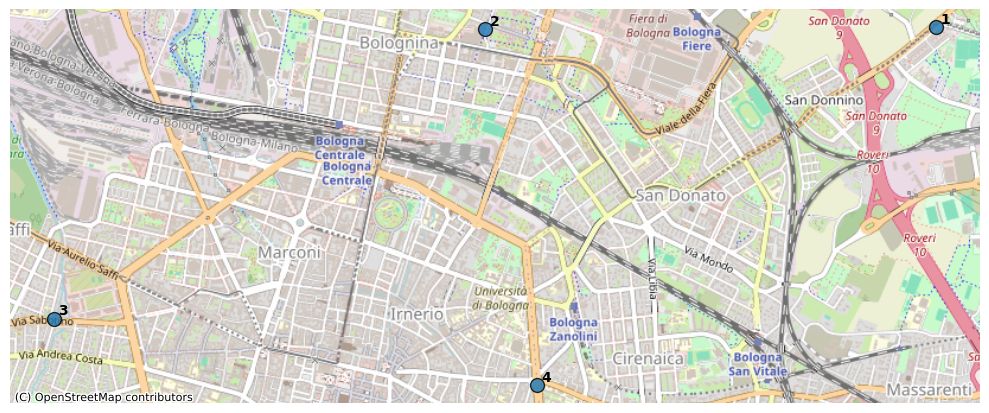

In [ ]:
pre_totals  = pre_policy .groupby('colonnina')['totale'].sum()
post_totals = post_policy_filtered.groupby('colonnina')['totale'].sum()


df = (
    pd.DataFrame({
        'pre':  pre_totals,
        'post': post_totals
    })
    .fillna(0)                 
    .assign(
        difference=lambda d: d['post'] - d['pre'],
        pct_change=lambda d: np.where(
            d['pre'] != 0,
            d['difference'] / d['pre'] * 100,
            0                  
        )
    )
    .reset_index()             
)


df['label'] = pd.qcut(df['difference'], 4, labels=False) + 1


df_export = df[['label','colonnina','difference','pct_change']].copy()


df_export.columns = [
    r"\textbf{Label}",
    r"\textbf{Colonnina}",
    r"\textbf{Difference}",
    r"\textbf{Pct Change (\%)}"
]


latex_table = df_export.to_latex(
    index=False,
    float_format="%.2f",
    column_format='lrrr',
    caption="Changes in Totale by Colonnina After 30 km/h Policy",
    label="tab:colonnina_changes",
    escape=False
)

print(latex_table)


geo_df = (
    pre_policy
      .drop_duplicates('colonnina')
      .set_index('colonnina')
)

geo_df = gpd.GeoDataFrame(
    geo_df,
    geometry='geo_point_2d',  
    crs="EPSG:4326"
)


geo_df = geo_df.join(
    df.set_index('colonnina')[['difference', 'label']],
    how='left'
)

geo_3857 = geo_df.to_crs(epsg=3857)

print(geo_3857)

fig, ax = plt.subplots(figsize=(10, 10))

geo_3857.plot(
    ax=ax,
    markersize=100,
    edgecolor='k',
    alpha=0.8,
    legend=True                
)

for idx, row in geo_3857.iterrows():
    pt = row['geo_point_2d']
    ax.annotate(
        str(int(row['label'])),
        xy=(pt.x, pt.y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )



ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:

rilevazione_flusso_veicoli_2024_gdf['data'] = pd.to_datetime(rilevazione_flusso_veicoli_2024_gdf['data'])

bike_buffers = colonnine_conta_bici.to_crs(epsg=3857).copy()
bike_buffers['geometry'] = bike_buffers.geometry.buffer(2000)

bike_buffers = bike_buffers[
    bike_buffers['colonnina'].isin(common_colonnine)
]

bike_buffers = bike_buffers.drop_duplicates(subset=['colonnina'])

bike_buffers = gpd.GeoDataFrame(
    bike_buffers[['colonnina']],        
    geometry=bike_buffers['geometry'],  
    crs='EPSG:3857'                     
)

try:
    rilevazione_flusso_veicoli_2024_gdf['car_count'] = rilevazione_flusso_veicoli_2024_gdf[hour_columns].sum(axis=1)
    rilevazione_flusso_veicoli_2024_gdf = rilevazione_flusso_veicoli_2024_gdf.drop(columns = hour_columns)
    rilevazione_flusso_veicoli_2024_gdf = rilevazione_flusso_veicoli_2024_gdf.to_crs(epsg=3857)
except:
    pass

car_in_buffer = gpd.sjoin(
    rilevazione_flusso_veicoli_2024_gdf,
    bike_buffers,
    how='inner',
    predicate='within'
)

In [23]:
car_agg = (
    car_in_buffer
    .groupby(['colonnina','data'], as_index=False)
    ['car_count']
    .sum()
)

car_agg['data'] = car_agg['data'].dt.tz_localize('Europe/Rome')

car_agg

colonnina                      data  car_count
0       Ercolani 2023-01-01 00:00:00+01:00     618069
1       Ercolani 2023-01-02 00:00:00+01:00     758724
2       Ercolani 2023-01-03 00:00:00+01:00     817871
3       Ercolani 2023-01-04 00:00:00+01:00     841744
4       Ercolani 2023-01-05 00:00:00+01:00     894587
...          ...                       ...        ...
3515  San Donato 2025-05-27 00:00:00+02:00     226264
3516  San Donato 2025-05-28 00:00:00+02:00     221582
3517  San Donato 2025-05-29 00:00:00+02:00     225881
3518  San Donato 2025-05-30 00:00:00+02:00     223777
3519  San Donato 2025-05-31 00:00:00+02:00     193040

[3520 rows x 3 columns]

In [ ]:
bike_df = (
    colonnine_conta_bici
      .rename(columns={'data_inizio': 'data', 'totale': 'bike_count'})
)


bike_df['data'] = (
    pd.to_datetime(bike_df['data'])
      .dt.normalize()                 
)


daily_bike_counts = (
    bike_df
      .groupby([
          'colonnina',
          pd.Grouper(key='data', freq='D')    
      ], as_index=False)
      .agg(daily_bike_count=('bike_count', 'sum'))
      .sort_values(['colonnina','data'])
)

start = pd.to_datetime('2023-01-04').tz_localize('Europe/Rome')
end   = pd.to_datetime('2025-01-04').tz_localize('Europe/Rome')


filtered_bikes = daily_bike_counts.loc[
    (daily_bike_counts['data'] >= start) &
    (daily_bike_counts['data'] <= end) &
    (daily_bike_counts['colonnina'].isin(common_colonnine))
].reset_index(drop=True)

filtered_bikes

colonnina                      data  daily_bike_count
0       Ercolani 2023-01-04 00:00:00+01:00            1270.0
1       Ercolani 2023-01-05 00:00:00+01:00            1279.0
2       Ercolani 2023-01-06 00:00:00+01:00             945.0
3       Ercolani 2023-01-07 00:00:00+01:00            1106.0
4       Ercolani 2023-01-08 00:00:00+01:00             821.0
...          ...                       ...               ...
2923  San Donato 2024-12-31 00:00:00+01:00             398.0
2924  San Donato 2025-01-01 00:00:00+01:00             275.0
2925  San Donato 2025-01-02 00:00:00+01:00             399.0
2926  San Donato 2025-01-03 00:00:00+01:00             376.0
2927  San Donato 2025-01-04 00:00:00+01:00             324.0

[2928 rows x 3 columns]

In [ ]:

filtered_bikes = filtered_bikes.rename(columns={'daily_bike_count':'bike_count'})

merged = pd.merge(
    car_agg[['colonnina','data','car_count']],
    filtered_bikes[['colonnina','data','bike_count']],
    on=['colonnina','data'],
    how='inner'  
)

merged

colonnina                      data  car_count  bike_count
0       Ercolani 2023-01-04 00:00:00+01:00     841744      1270.0
1       Ercolani 2023-01-05 00:00:00+01:00     894587      1279.0
2       Ercolani 2023-01-06 00:00:00+01:00     685867       945.0
3       Ercolani 2023-01-07 00:00:00+01:00     805702      1106.0
4       Ercolani 2023-01-08 00:00:00+01:00     680359       821.0
...          ...                       ...        ...         ...
2915  San Donato 2024-12-31 00:00:00+01:00     164461       398.0
2916  San Donato 2025-01-01 00:00:00+01:00     112349       275.0
2917  San Donato 2025-01-02 00:00:00+01:00     174793       399.0
2918  San Donato 2025-01-03 00:00:00+01:00     188095       376.0
2919  San Donato 2025-01-04 00:00:00+01:00     176020       324.0

[2920 rows x 4 columns]

In [ ]:

precipitazioni['date'] = pd.to_datetime(precipitazioni['date'])

temperature['date'] = pd.to_datetime(temperature['date'])
clima = pd.merge(precipitazioni, temperature, on='date', how='outer')
clima['data'] = pd.to_datetime(clima['date'])\
                   .dt.tz_localize('Europe/Rome')

In [ ]:
clima = clima.rename(columns={'184_avg_d':'rain_mm'})


panel_df = pd.merge(
    merged, 
    clima,
    on='data',
    how='left'  
)

panel_df['wet'] = panel_df['rain_mm'] != 0


In [28]:
panel_df

colonnina                      data  car_count  bike_count       date  \
0       Ercolani 2023-01-04 00:00:00+01:00     841744      1270.0 2023-01-04   
1       Ercolani 2023-01-05 00:00:00+01:00     894587      1279.0 2023-01-05   
2       Ercolani 2023-01-06 00:00:00+01:00     685867       945.0 2023-01-06   
3       Ercolani 2023-01-07 00:00:00+01:00     805702      1106.0 2023-01-07   
4       Ercolani 2023-01-08 00:00:00+01:00     680359       821.0 2023-01-08   
...          ...                       ...        ...         ...        ...   
2915  San Donato 2024-12-31 00:00:00+01:00     164461       398.0 2024-12-31   
2916  San Donato 2025-01-01 00:00:00+01:00     112349       275.0 2025-01-01   
2917  San Donato 2025-01-02 00:00:00+01:00     174793       399.0 2025-01-02   
2918  San Donato 2025-01-03 00:00:00+01:00     188095       376.0 2025-01-03   
2919  San Donato 2025-01-04 00:00:00+01:00     176020       324.0 2025-01-04   

      rain_mm stagione_x  avg   max  min stagione_y    wet  
0         0.0    Inverno  9.6  10.8  7.6    Inverno  False  
1         0.0    Inverno  8.4  11.9  4.9    Inverno  False  
2         0.1    Inverno  8.0   9.5  6.0    Inverno   True  
3         0.0    Inverno  9.2  10.6  8.2    Inverno  False  
4         1.1    Inverno  9.2  12.4  7.1    Inverno   True  
...       ...        ...  ...   ...  ...        ...    ...  
2915      0.0    Inverno  6.2  10.8  2.7    Inverno  False  
2916      0.0    Inverno  5.3   9.9  1.0    Inverno  False  
2917      0.0    Inverno  5.1  10.3  0.5    Inverno  False  
2918      0.3    Inverno  4.6   6.9  2.4    Inverno   True  
2919      0.0    Inverno  2.8   4.8  0.3    Inverno  False  

[2920 rows x 12 columns]

In [29]:

panel_pre = panel_df[
    panel_df['data'].between('2023-01-04', '2024-01-03')
]

panel_post = panel_df[
    panel_df['data'].between('2024-01-04', '2025-01-03')
]

panel_pre = panel_pre.set_index(['colonnina','data']).sort_index()
panel_post = panel_post.set_index(['colonnina','data']).sort_index()
panel_df = panel_df.set_index(['colonnina','data']).sort_index()

In [30]:



y = panel_df['bike_count']
X = panel_df[['car_count', 'avg', 'rain_mm']]  
X = sm.add_constant(X)

mod = PanelOLS(y,
               X,
               entity_effects=True,    # station fixed effects
               time_effects=True,       # time fixed effects (hour/day)
                drop_absorbed=True 
              )
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:             bike_count   R-squared:                        0.2606
Estimator:                   PanelOLS   R-squared (Between):              0.5543
No. Observations:                2920   R-squared (Within):               0.2684
Date:                mar, ago 26 2025   R-squared (Overall):              0.4588
Time:                        09:57:34   Log-likelihood                -2.133e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      770.58
Entities:                           4   P-value                           0.0000
Avg Obs:                       730.00   Distribution:                  F(1,2186)
Min Obs:                       730.00                                           
Max Obs:                       730.00   F-statistic (robust):             20.861
                            

/tmp/ipykernel_47332/4251911148.py:11: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

avg, rain_mm

  res = mod.fit(cov_type='clustered', cluster_entity=True)


In [ ]:
panel_daily = panel_df
#  Station fixed‐effects + explicit weather (no time FE)
y = panel_daily['bike_count']
X_weather = panel_daily[['car_count', 'rain_mm', 'avg']]
X_weather = sm.add_constant(X_weather)

mod_weather = PanelOLS(
    y,
    X_weather,
    entity_effects=True,    # station FE
    time_effects=False,     # drop global time FE so weather dummies stay
    drop_absorbed=True
)
res_weather = mod_weather.fit(
    cov_type='clustered',
    cluster_entity=True
)
print(res_weather.summary)


# 2) Interaction of car_count with post_policy dummy
panel_daily = panel_daily.reset_index()
panel_daily['post_policy'] = (
    panel_daily['data']
    .between('2024-01-04', '2025-01-03')
    .astype(int)
)
panel_daily['car_post'] = panel_daily['car_count'] * panel_daily['post_policy']

y_int = panel_daily.set_index(['colonnina','data'])['bike_count']
X_int = panel_daily.set_index(['colonnina','data'])[
    ['car_count', 'car_post', 'rain_mm', 'avg']
]
X_int = sm.add_constant(X_int)

mod_int = PanelOLS(
    y_int,
    X_int,
    entity_effects=True,
    time_effects=False,
    drop_absorbed=True
)
res_int = mod_int.fit(cov_type='clustered', cluster_entity=True)
print(res_int.summary)


# 3) Separate pre‐ and post‐policy estimates

for name, panel in [('pre', panel_pre), ('post', panel_post)]:
    panel = panel.reset_index().groupby(['colonnina', pd.Grouper(key='data', freq='D')])\
                   .agg({'bike_count':'sum','car_count':'sum',
                         'rain_mm':'mean','avg':'mean'})\
                   .reset_index().set_index(['colonnina','data'])
    y_sub = panel['bike_count']
    X_sub = sm.add_constant(panel[['car_count','rain_mm','avg']])
    mod_sub = PanelOLS(
        y_sub,
        X_sub,
        entity_effects=True,
        time_effects=False,
        drop_absorbed=True
    )
    res_sub = mod_sub.fit(cov_type='clustered', cluster_entity=True)
    print(f"\n*** {name.upper()} POLICY RESULTS ***")
    print(res_sub.summary)


# 4) Model D: Nonlinear effects (quadratic term)
panel_daily['car_count_sq'] = panel_daily['car_count'] ** 2
y_q = panel_daily.set_index(['colonnina','data'])['bike_count']
X_q = panel_daily.set_index(['colonnina','data'])[
    ['car_count', 'car_count_sq', 'rain_mm', 'avg']
]
X_q = sm.add_constant(X_q)

mod_quad = PanelOLS(
    y_q,
    X_q,
    entity_effects=True,
    time_effects=False,
    drop_absorbed=True,
    check_rank=False
)
res_quad = mod_quad.fit(cov_type='clustered', cluster_entity=True)
print(res_quad.summary)


# 5) Alternative SE clustering: by date instead of station
res_weather_time_clustered = mod_weather.fit(
    cov_type='clustered', cluster_time=True
)
print("\n*** Weather model, clustered by time ***")
print(res_weather_time_clustered.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:             bike_count   R-squared:                        0.4782
Estimator:                   PanelOLS   R-squared (Between):              0.5683
No. Observations:                2920   R-squared (Within):               0.4782
Date:                mar, ago 26 2025   R-squared (Overall):              0.5382
Time:                        09:58:04   Log-likelihood                -2.245e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      890.03
Entities:                           4   P-value                           0.0000
Avg Obs:                       730.00   Distribution:                  F(3,2913)
Min Obs:                       730.00                                           
Max Obs:                       730.00   F-statistic (robust):             6.0676
                            

/tmp/ipykernel_47332/2019331466.py:86: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

rain_mm, avg

  res_quad = mod_quad.fit(cov_type='clustered', cluster_entity=True)


periodo                       0
km_urbano_bologna             0
km_bacino_bologna             0
validazioni_urbano_bologna    0
validazioni_bacino_bologna    0
dtype: int64


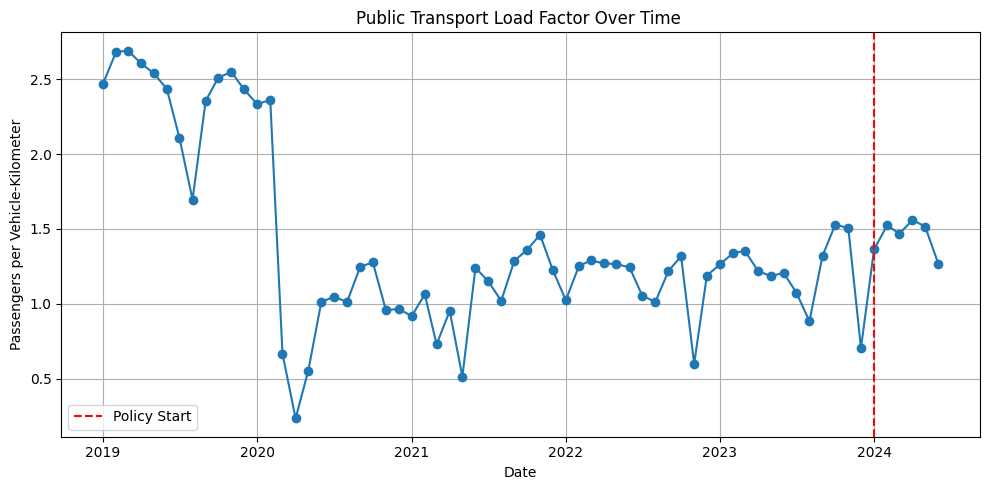

                            OLS Regression Results                            
Dep. Variable:            load_factor   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                 -0.141
Method:                 Least Squares   F-statistic:                    0.3313
Date:                mar, 26 ago 2025   Prob (F-statistic):              0.980
Time:                        09:58:33   Log-Likelihood:                -56.486
No. Observations:                  66   AIC:                             139.0
Df Residuals:                      53   BIC:                             167.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.5590      0.264      5.

In [ ]:
df = tpl_validazioni_km
df["periodo"] = pd.to_datetime(df["periodo"]) 
df = df.sort_values("periodo")
print(df.isnull().sum())

df["vkm_urbano"] = df["km_urbano_bologna"]
df["validazioni_urbano"] = df["validazioni_urbano_bologna"]
df["load_factor"] = df["validazioni_urbano"] / df["vkm_urbano"]


policy_date = pd.to_datetime("2024-01-01")
df["post_policy"] = (df["periodo"] >= policy_date).astype(int)

df["month"] = df["periodo"].dt.month.astype(str)

plt.figure(figsize=(10, 5))
plt.plot(df["periodo"], df["load_factor"], marker="o")
plt.axvline(policy_date, color="red", linestyle="--", label="Policy Start")
plt.title("Public Transport Load Factor Over Time ")
plt.xlabel("Date")
plt.ylabel("Passengers per Vehicle-Kilometer")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Regression: effect of policy on load factor
model = smf.ols("load_factor ~ post_policy + C(month)", data=df).fit()
print(model.summary())